# 04 - Multi-layer NN per Ticker

This notebook trains a multi-layer neural network on each ticker to evaluate performance improvement from increased model depth.


Training AAPL...
Training AAPL model (v4)...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/12 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 3.3702
Epoch 1: val_loss improved from inf to 0.54283, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.6979 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3160
Epoch 2: val_loss improved from 0.54283 to 0.43274, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5475 - val_loss: 0.4327 - learning_rate: 0.0010
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.4182
Epoch 3: val_loss improved from 0.43274 to 0.40000, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.1734 - val_loss: 0.4000 - learning_rate: 0.0010
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8031
Epoch 4: val_loss improved from 0.40000 to 0.36909, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9460 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 5/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9244
Epoch 5: val_loss improved from 0.36909 to 0.34725, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8481 - val_loss: 0.3473 - learning_rate: 0.0010
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8230
Epoch 6: val_loss improved from 0.34725 to 0.33721, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7613 - val_loss: 0.3372 - learning_rate: 0.0010
Epoch 7/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7922
Epoch 7: val_loss improved from 0.33721 to 0.32907, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7840 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 8/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6559
Epoch 8: val_loss improved from 0.32907 to 0.30273, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7567 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 9/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6053
Epoch 9: val_loss improved from 0.30273 to 0.27990, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6976 - val_loss: 0.2799 - learning_rate: 0.0010
Epoch 10/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5826
Epoch 10: val_loss improved from 0.27990 to 0.26246, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7133 - val_loss: 0.2625 - learning_rate: 0.0010
Epoch 11/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4922
Epoch 11: val_loss improved from 0.26246 to 0.25068, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6317 - val_loss: 0.2507 - learning_rate: 0.0010
Epoch 12/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6486
Epoch 12: val_loss improved from 0.25068 to 0.24277, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6844 - val_loss: 0.2428 - learning_rate: 0.0010
Epoch 13/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4487
Epoch 13: val_loss improved from 0.24277 to 0.23723, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5975 - val_loss: 0.2372 - learning_rate: 0.0010
Epoch 14/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3793
Epoch 14: val_loss improved from 0.23723 to 0.22388, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5261 - val_loss: 0.2239 - learning_rate: 0.0010
Epoch 15/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3104
Epoch 15: val_loss improved from 0.22388 to 0.20971, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4896 - val_loss: 0.2097 - learning_rate: 0.0010
Epoch 16/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3983
Epoch 16: val_loss improved from 0.20971 to 0.20465, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5136 - val_loss: 0.2046 - learning_rate: 0.0010
Epoch 17/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5963
Epoch 17: val_loss improved from 0.20465 to 0.19514, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5745 - val_loss: 0.1951 - learning_rate: 0.0010
Epoch 18/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3500
Epoch 18: val_loss improved from 0.19514 to 0.18614, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4708 - val_loss: 0.1861 - learning_rate: 0.0010
Epoch 19/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4050
Epoch 19: val_loss improved from 0.18614 to 0.18073, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5171 - val_loss: 0.1807 - learning_rate: 0.0010
Epoch 20/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6104
Epoch 20: val_loss did not improve from 0.18073
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5298 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 21/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3628
Epoch 21: val_loss improved from 0.18073 to 0.17547, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5087 - val_loss: 0.1755 - learning_rate: 0.0010
Epoch 22/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5018
Epoch 22: val_loss improved from 0.17547 to 0.16967, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5103 - val_loss: 0.1697 - learning_rate: 0.0010
Epoch 23/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4055
Epoch 23: val_loss improved from 0.16967 to 0.16850, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5030 - val_loss: 0.1685 - learning_rate: 0.0010
Epoch 24/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4114
Epoch 24: val_loss did not improve from 0.16850
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4801 - val_loss: 0.1713 - learning_rate: 0.0010
Epoch 25/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4792
Epoch 25: val_loss improved from 0.16850 to 0.16771, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5049 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 26/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3423
Epoch 26: val_loss improved from 0.16771 to 0.15823, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4776 - val_loss: 0.1582 - learning_rate: 0.0010
Epoch 27/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3764
Epoch 27: val_loss improved from 0.15823 to 0.15193, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4614 - val_loss: 0.1519 - learning_rate: 0.0010
Epoch 28/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4211
Epoch 28: val_loss improved from 0.15193 to 0.15186, saving model to ../models/saved_model/AAPL_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4595 - val_loss: 0.1519 - learning_rate: 0.0010
Epoch 29/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3299
Epoch 29: val_loss did not improve from 0.15186
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4106 - val_loss: 0.1582 - learning_rate: 0.0010
Epoch 30/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4858
Epoch 30: val_loss did not improve from 0.15186
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4521 - val_loss: 0.1627 - learning_rate: 0.0010
Epoch 31/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5983
Epoch 31: val_loss did not improve from 0.15186
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4986 - val_loss: 0.1669 - learning_rate: 0.0010
Epoch 32/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4020
Epoch 32: val_loss did not improve from 0.15186
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4068 - val_loss: 0.1659 - learning_rate: 0.0010
Epoch 33/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/st

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


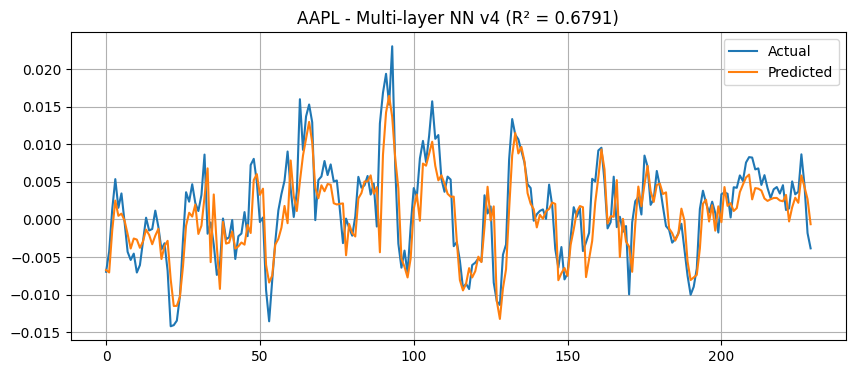


Training MSFT...
Training MSFT model (v4)...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 4.0435
Epoch 1: val_loss improved from inf to 0.45221, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.5406 - val_loss: 0.4522 - learning_rate: 0.0010
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8561
Epoch 2: val_loss improved from 0.45221 to 0.43615, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8925 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0770
Epoch 3: val_loss improved from 0.43615 to 0.42654, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5235 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1072
Epoch 4: val_loss improved from 0.42654 to 0.38947, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1905 - val_loss: 0.3895 - learning_rate: 0.0010
Epoch 5/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1929
Epoch 5: val_loss improved from 0.38947 to 0.35609, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2117 - val_loss: 0.3561 - learning_rate: 0.0010
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0355
Epoch 6: val_loss improved from 0.35609 to 0.32561, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0599 - val_loss: 0.3256 - learning_rate: 0.0010
Epoch 7/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.1550
Epoch 7: val_loss improved from 0.32561 to 0.31857, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0303 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 8/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7497
Epoch 8: val_loss improved from 0.31857 to 0.31437, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9182 - val_loss: 0.3144 - learning_rate: 0.0010
Epoch 9/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0445
Epoch 9: val_loss improved from 0.31437 to 0.29722, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0048 - val_loss: 0.2972 - learning_rate: 0.0010
Epoch 10/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8499
Epoch 10: val_loss improved from 0.29722 to 0.27874, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8399 - val_loss: 0.2787 - learning_rate: 0.0010
Epoch 11/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6850
Epoch 11: val_loss improved from 0.27874 to 0.26936, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7952 - val_loss: 0.2694 - learning_rate: 0.0010
Epoch 12/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8258
Epoch 12: val_loss improved from 0.26936 to 0.26483, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8287 - val_loss: 0.2648 - learning_rate: 0.0010
Epoch 13/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9241
Epoch 13: val_loss improved from 0.26483 to 0.25089, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8435 - val_loss: 0.2509 - learning_rate: 0.0010
Epoch 14/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7809
Epoch 14: val_loss improved from 0.25089 to 0.24525, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7230 - val_loss: 0.2453 - learning_rate: 0.0010
Epoch 15/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7656
Epoch 15: val_loss improved from 0.24525 to 0.24479, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8574 - val_loss: 0.2448 - learning_rate: 0.0010
Epoch 16/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5489
Epoch 16: val_loss improved from 0.24479 to 0.23970, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7128 - val_loss: 0.2397 - learning_rate: 0.0010
Epoch 17/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6656
Epoch 17: val_loss improved from 0.23970 to 0.23703, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7073 - val_loss: 0.2370 - learning_rate: 0.0010
Epoch 18/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7591
Epoch 18: val_loss improved from 0.23703 to 0.23238, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7724 - val_loss: 0.2324 - learning_rate: 0.0010
Epoch 19/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8287
Epoch 19: val_loss improved from 0.23238 to 0.22959, saving model to ../models/saved_model/MSFT_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7344 - val_loss: 0.2296 - learning_rate: 0.0010
Epoch 20/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6466
Epoch 20: val_loss did not improve from 0.22959
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6021 - val_loss: 0.2356 - learning_rate: 0.0010
Epoch 21/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6416
Epoch 21: val_loss did not improve from 0.22959
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6625 - val_loss: 0.2333 - learning_rate: 0.0010
Epoch 22/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5905
Epoch 22: val_loss did not improve from 0.22959
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6259 - val_loss: 0.2320 - learning_rate: 0.0010
Epoch 23/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4511
Epoch 23: val_loss did not improve from 0.22959
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6522 - val_loss: 0.2363 - learning_rate: 0.0010
Epoch 24/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


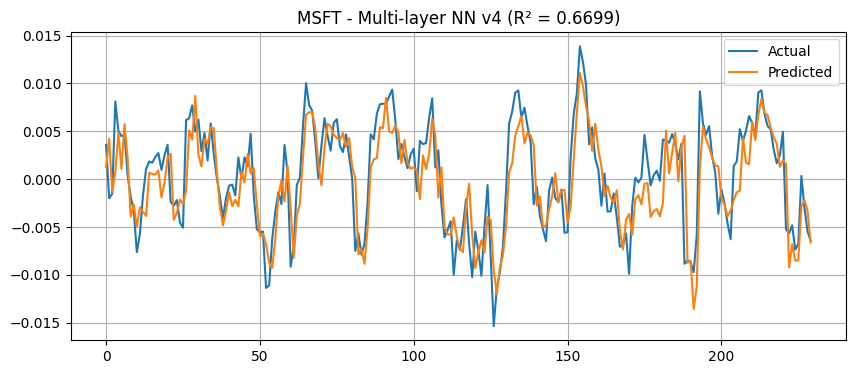


Training JPM...
Training JPM model (v4)...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 4.5266
Epoch 1: val_loss improved from inf to 0.31016, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.8400 - val_loss: 0.3102 - learning_rate: 0.0010
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1150
Epoch 2: val_loss did not improve from 0.31016
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2785 - val_loss: 0.3176 - learning_rate: 0.0010
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1090
Epoch 3: val_loss did not improve from 0.31016
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0730 - val_loss: 0.3333 - learning_rate: 0.0010
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0455
Epoch 4: val_loss did not improve from 0.31016
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9892 - val_loss: 0.3229 - learning_rate: 0.0010
Epoch 5/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9634
Epoch 5: val_loss did not improve from 0.31016
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9359 - val_loss: 0.3130 - learning_rate: 0.0010
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8603 - val_loss: 0.3071 - learning_rate: 0.0010
Epoch 7/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8175
Epoch 7: val_loss did not improve from 0.30707
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7744 - val_loss: 0.3088 - learning_rate: 0.0010
Epoch 8/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9631
Epoch 8: val_loss did not improve from 0.30707
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7659 - val_loss: 0.3156 - learning_rate: 0.0010
Epoch 9/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6596
Epoch 9: val_loss did not improve from 0.30707
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7171 - val_loss: 0.3075 - learning_rate: 0.0010
Epoch 10/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9112
Epoch 10: val_loss improved from 0.30707 to 0.29793, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7486 - val_loss: 0.2979 - learning_rate: 0.0010
Epoch 11/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6813
Epoch 11: val_loss improved from 0.29793 to 0.29677, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6117 - val_loss: 0.2968 - learning_rate: 0.0010
Epoch 12/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7846
Epoch 12: val_loss improved from 0.29677 to 0.27723, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6112 - val_loss: 0.2772 - learning_rate: 0.0010
Epoch 13/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6878
Epoch 13: val_loss did not improve from 0.27723
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6497 - val_loss: 0.2772 - learning_rate: 0.0010
Epoch 14/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6927
Epoch 14: val_loss improved from 0.27723 to 0.26712, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6085 - val_loss: 0.2671 - learning_rate: 0.0010
Epoch 15/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6127
Epoch 15: val_loss improved from 0.26712 to 0.25479, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6213 - val_loss: 0.2548 - learning_rate: 0.0010
Epoch 16/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4688
Epoch 16: val_loss improved from 0.25479 to 0.23720, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6066 - val_loss: 0.2372 - learning_rate: 0.0010
Epoch 17/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7733
Epoch 17: val_loss improved from 0.23720 to 0.22429, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5741 - val_loss: 0.2243 - learning_rate: 0.0010
Epoch 18/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6618
Epoch 18: val_loss improved from 0.22429 to 0.21527, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5987 - val_loss: 0.2153 - learning_rate: 0.0010
Epoch 19/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6270
Epoch 19: val_loss improved from 0.21527 to 0.21342, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5514 - val_loss: 0.2134 - learning_rate: 0.0010
Epoch 20/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6301
Epoch 20: val_loss improved from 0.21342 to 0.20065, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5804 - val_loss: 0.2006 - learning_rate: 0.0010
Epoch 21/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4876
Epoch 21: val_loss did not improve from 0.20065
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5472 - val_loss: 0.2054 - learning_rate: 0.0010
Epoch 22/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6325
Epoch 22: val_loss did not improve from 0.20065
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5394 - val_loss: 0.2035 - learning_rate: 0.0010
Epoch 23/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7065
Epoch 23: val_loss improved from 0.20065 to 0.19339, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5753 - val_loss: 0.1934 - learning_rate: 0.0010
Epoch 24/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5176
Epoch 24: val_loss improved from 0.19339 to 0.18376, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5182 - val_loss: 0.1838 - learning_rate: 0.0010
Epoch 25/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5502
Epoch 25: val_loss improved from 0.18376 to 0.17654, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5074 - val_loss: 0.1765 - learning_rate: 0.0010
Epoch 26/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6314
Epoch 26: val_loss improved from 0.17654 to 0.16920, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5280 - val_loss: 0.1692 - learning_rate: 0.0010
Epoch 27/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7305
Epoch 27: val_loss did not improve from 0.16920
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5124 - val_loss: 0.1730 - learning_rate: 0.0010
Epoch 28/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5441
Epoch 28: val_loss did not improve from 0.16920
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5301 - val_loss: 0.1711 - learning_rate: 0.0010
Epoch 29/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4718
Epoch 29: val_loss improved from 0.16920 to 0.16073, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4761 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 30/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5991
Epoch 30: val_loss improved from 0.16073 to 0.16016, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4702 - val_loss: 0.1602 - learning_rate: 0.0010
Epoch 31/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6412
Epoch 31: val_loss did not improve from 0.16016
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4711 - val_loss: 0.1628 - learning_rate: 0.0010
Epoch 32/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4346
Epoch 32: val_loss improved from 0.16016 to 0.15778, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4258 - val_loss: 0.1578 - learning_rate: 0.0010
Epoch 33/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5790
Epoch 33: val_loss did not improve from 0.15778
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4554 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 34/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4108
Epoch 34: val_loss did not improve from 0.15778
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4622 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 35/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6015
Epoch 35: val_loss did not improve from 0.15778
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4780 - val_loss: 0.1583 - learning_rate: 0.0010
Epoch 36/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6115
Epoch 36: val_loss did not improve from 0.15778
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4625 - val_loss: 0.1588 - learning_rate: 0.0010
Epoch 37/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/st

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4321 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 40/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6312
Epoch 40: val_loss did not improve from 0.15685
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4705 - val_loss: 0.1575 - learning_rate: 0.0010
Epoch 41/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4433
Epoch 41: val_loss improved from 0.15685 to 0.15342, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4557 - val_loss: 0.1534 - learning_rate: 0.0010
Epoch 42/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5423
Epoch 42: val_loss did not improve from 0.15342
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4395 - val_loss: 0.1580 - learning_rate: 0.0010
Epoch 43/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6057
Epoch 43: val_loss did not improve from 0.15342
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4682 - val_loss: 0.1580 - learning_rate: 0.0010
Epoch 44/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4424
Epoch 44: val_loss did not improve from 0.15342
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4074 - val_loss: 0.1558 - learning_rate: 0.0010
Epoch 45/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4537
Epoch 45: val_loss did not improve from 0.15342
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3994 - val_loss: 0.1589 - learning_rate: 0.0010
Epoch 46/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/st

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4017 - val_loss: 0.1513 - learning_rate: 0.0010
Epoch 49/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3576
Epoch 49: val_loss improved from 0.15131 to 0.14996, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3893 - val_loss: 0.1500 - learning_rate: 0.0010
Epoch 50/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4849
Epoch 50: val_loss improved from 0.14996 to 0.14983, saving model to ../models/saved_model/JPM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4010 - val_loss: 0.1498 - learning_rate: 0.0010
Epoch 51/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3569
Epoch 51: val_loss did not improve from 0.14983
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3547 - val_loss: 0.1593 - learning_rate: 0.0010
Epoch 52/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3865
Epoch 52: val_loss did not improve from 0.14983
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3741 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 53/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3799
Epoch 53: val_loss did not improve from 0.14983
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3855 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 54/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4632
Epoch 54: val_loss did not improve from 0.14983
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3918 - val_loss: 0.1586 - learning_rate: 0.0010
Epoch 55/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/st

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


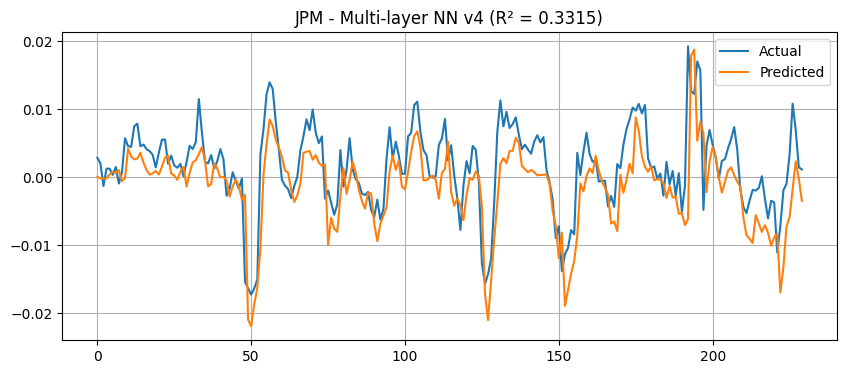


Training BAC...
Training BAC model (v4)...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/12 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - loss: 5.7858
Epoch 1: val_loss improved from inf to 0.71893, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.7231 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4280
Epoch 2: val_loss improved from 0.71893 to 0.59159, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5352 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.4996
Epoch 3: val_loss improved from 0.59159 to 0.56375, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3230 - val_loss: 0.5638 - learning_rate: 0.0010
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8640
Epoch 4: val_loss improved from 0.56375 to 0.54875, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9818 - val_loss: 0.5487 - learning_rate: 0.0010
Epoch 5/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0952
Epoch 5: val_loss improved from 0.54875 to 0.49902, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9881 - val_loss: 0.4990 - learning_rate: 0.0010
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7983
Epoch 6: val_loss improved from 0.49902 to 0.47507, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8557 - val_loss: 0.4751 - learning_rate: 0.0010
Epoch 7/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8030
Epoch 7: val_loss did not improve from 0.47507
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8699 - val_loss: 0.4848 - learning_rate: 0.0010
Epoch 8/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7082
Epoch 8: val_loss did not improve from 0.47507
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8027 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 9/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5404
Epoch 9: val_loss did not improve from 0.47507
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6228 - val_loss: 0.4786 - learning_rate: 0.0010
Epoch 10/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5288
Epoch 10: val_loss improved from 0.47507 to 0.46679, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6301 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 11/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5472
Epoch 11: val_loss improved from 0.46679 to 0.45345, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5906 - val_loss: 0.4535 - learning_rate: 0.0010
Epoch 12/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6597
Epoch 12: val_loss improved from 0.45345 to 0.42207, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6738 - val_loss: 0.4221 - learning_rate: 0.0010
Epoch 13/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6276
Epoch 13: val_loss improved from 0.42207 to 0.39885, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6587 - val_loss: 0.3989 - learning_rate: 0.0010
Epoch 14/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6130
Epoch 14: val_loss improved from 0.39885 to 0.36900, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5845 - val_loss: 0.3690 - learning_rate: 0.0010
Epoch 15/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4184
Epoch 15: val_loss improved from 0.36900 to 0.34963, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5524 - val_loss: 0.3496 - learning_rate: 0.0010
Epoch 16/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5888
Epoch 16: val_loss improved from 0.34963 to 0.33811, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5793 - val_loss: 0.3381 - learning_rate: 0.0010
Epoch 17/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7298
Epoch 17: val_loss improved from 0.33811 to 0.33340, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6150 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 18/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5833
Epoch 18: val_loss improved from 0.33340 to 0.31229, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5383 - val_loss: 0.3123 - learning_rate: 0.0010
Epoch 19/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4875
Epoch 19: val_loss improved from 0.31229 to 0.28892, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4940 - val_loss: 0.2889 - learning_rate: 0.0010
Epoch 20/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5256
Epoch 20: val_loss improved from 0.28892 to 0.28223, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5150 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 21/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4043
Epoch 21: val_loss improved from 0.28223 to 0.26577, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5123 - val_loss: 0.2658 - learning_rate: 0.0010
Epoch 22/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3865
Epoch 22: val_loss improved from 0.26577 to 0.24188, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4465 - val_loss: 0.2419 - learning_rate: 0.0010
Epoch 23/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5239
Epoch 23: val_loss improved from 0.24188 to 0.23402, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5269 - val_loss: 0.2340 - learning_rate: 0.0010
Epoch 24/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5553
Epoch 24: val_loss improved from 0.23402 to 0.23220, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4557 - val_loss: 0.2322 - learning_rate: 0.0010
Epoch 25/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5771
Epoch 25: val_loss improved from 0.23220 to 0.22456, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4834 - val_loss: 0.2246 - learning_rate: 0.0010
Epoch 26/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4364
Epoch 26: val_loss improved from 0.22456 to 0.21872, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4370 - val_loss: 0.2187 - learning_rate: 0.0010
Epoch 27/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8126
Epoch 27: val_loss improved from 0.21872 to 0.21381, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5607 - val_loss: 0.2138 - learning_rate: 0.0010
Epoch 28/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3897
Epoch 28: val_loss improved from 0.21381 to 0.21015, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4713 - val_loss: 0.2101 - learning_rate: 0.0010
Epoch 29/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6123
Epoch 29: val_loss improved from 0.21015 to 0.20350, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4926 - val_loss: 0.2035 - learning_rate: 0.0010
Epoch 30/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4532
Epoch 30: val_loss did not improve from 0.20350
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3890 - val_loss: 0.2040 - learning_rate: 0.0010
Epoch 31/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4420
Epoch 31: val_loss improved from 0.20350 to 0.20280, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4254 - val_loss: 0.2028 - learning_rate: 0.0010
Epoch 32/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4886
Epoch 32: val_loss improved from 0.20280 to 0.20116, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4299 - val_loss: 0.2012 - learning_rate: 0.0010
Epoch 33/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3581
Epoch 33: val_loss improved from 0.20116 to 0.20098, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3909 - val_loss: 0.2010 - learning_rate: 0.0010
Epoch 34/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4732
Epoch 34: val_loss improved from 0.20098 to 0.19845, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4122 - val_loss: 0.1985 - learning_rate: 0.0010
Epoch 35/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4928
Epoch 35: val_loss improved from 0.19845 to 0.19594, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4178 - val_loss: 0.1959 - learning_rate: 0.0010
Epoch 36/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4010
Epoch 36: val_loss did not improve from 0.19594
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3690 - val_loss: 0.1963 - learning_rate: 0.0010
Epoch 37/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3900
Epoch 37: val_loss improved from 0.19594 to 0.19466, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4158 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 38/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3903
Epoch 38: val_loss did not improve from 0.19466
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3613 - val_loss: 0.1955 - learning_rate: 0.0010
Epoch 39/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3070
Epoch 39: val_loss did not improve from 0.19466
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3509 - val_loss: 0.1955 - learning_rate: 0.0010
Epoch 40/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3992
Epoch 40: val_loss improved from 0.19466 to 0.19371, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3844 - val_loss: 0.1937 - learning_rate: 0.0010
Epoch 41/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3704
Epoch 41: val_loss improved from 0.19371 to 0.19353, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3498 - val_loss: 0.1935 - learning_rate: 0.0010
Epoch 42/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3720
Epoch 42: val_loss improved from 0.19353 to 0.19330, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3683 - val_loss: 0.1933 - learning_rate: 0.0010
Epoch 43/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3593
Epoch 43: val_loss improved from 0.19330 to 0.19287, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3570 - val_loss: 0.1929 - learning_rate: 0.0010
Epoch 44/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4099
Epoch 44: val_loss improved from 0.19287 to 0.19287, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3845 - val_loss: 0.1929 - learning_rate: 0.0010
Epoch 45/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4364
Epoch 45: val_loss improved from 0.19287 to 0.19227, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3752 - val_loss: 0.1923 - learning_rate: 0.0010
Epoch 46/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4296
Epoch 46: val_loss improved from 0.19227 to 0.19110, saving model to ../models/saved_model/BAC_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3614 - val_loss: 0.1911 - learning_rate: 0.0010
Epoch 47/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3575
Epoch 47: val_loss did not improve from 0.19110
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3573 - val_loss: 0.1924 - learning_rate: 0.0010
Epoch 48/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3675
Epoch 48: val_loss did not improve from 0.19110
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3721 - val_loss: 0.1935 - learning_rate: 0.0010
Epoch 49/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3522
Epoch 49: val_loss did not improve from 0.19110
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3276 - val_loss: 0.1956 - learning_rate: 0.0010
Epoch 50/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4496
Epoch 50: val_loss did not improve from 0.19110
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3680 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 51/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/s

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3167 - val_loss: 0.1900 - learning_rate: 0.0010
Epoch 54/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3563
Epoch 54: val_loss did not improve from 0.18996
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3326 - val_loss: 0.1914 - learning_rate: 0.0010
Epoch 55/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3001
Epoch 55: val_loss did not improve from 0.18996
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3216 - val_loss: 0.1921 - learning_rate: 0.0010
Epoch 56/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3460
Epoch 56: val_loss did not improve from 0.18996
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3387 - val_loss: 0.1922 - learning_rate: 0.0010
Epoch 57/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3817
Epoch 57: val_loss did not improve from 0.18996
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3326 - val_loss: 0.1910 - learning_rate: 0.0010
Epoch 58/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/st

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


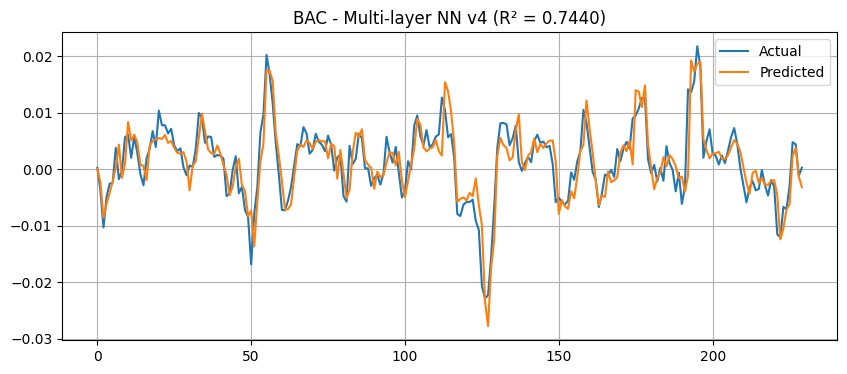


Training XOM...
Training XOM model (v4)...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/12 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 3.2133
Epoch 1: val_loss improved from inf to 0.45775, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.9958 - val_loss: 0.4578 - learning_rate: 0.0010
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9422
Epoch 2: val_loss improved from 0.45775 to 0.42535, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.8457 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1187
Epoch 3: val_loss improved from 0.42535 to 0.42410, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3582 - val_loss: 0.4241 - learning_rate: 0.0010
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4022
Epoch 4: val_loss improved from 0.42410 to 0.41762, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2904 - val_loss: 0.4176 - learning_rate: 0.0010
Epoch 5/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0041
Epoch 5: val_loss improved from 0.41762 to 0.39202, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1635 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8894
Epoch 6: val_loss improved from 0.39202 to 0.38237, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0986 - val_loss: 0.3824 - learning_rate: 0.0010
Epoch 7/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9213
Epoch 7: val_loss improved from 0.38237 to 0.36522, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.9744 - val_loss: 0.3652 - learning_rate: 0.0010
Epoch 8/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0741
Epoch 8: val_loss improved from 0.36522 to 0.35853, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9901 - val_loss: 0.3585 - learning_rate: 0.0010
Epoch 9/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7332
Epoch 9: val_loss did not improve from 0.35853
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8893 - val_loss: 0.3714 - learning_rate: 0.0010
Epoch 10/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9049
Epoch 10: val_loss did not improve from 0.35853
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9157 - val_loss: 0.3653 - learning_rate: 0.0010
Epoch 11/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7573
Epoch 11: val_loss did not improve from 0.35853
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8096 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 12/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7865
Epoch 12: val_loss did not improve from 0.35853
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8589 - val_loss: 0.3709 - learning_rate: 0.0010
Epoch 13/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6415 - val_loss: 0.3477 - learning_rate: 0.0010
Epoch 17/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5606
Epoch 17: val_loss improved from 0.34766 to 0.32522, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7106 - val_loss: 0.3252 - learning_rate: 0.0010
Epoch 18/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4552
Epoch 18: val_loss improved from 0.32522 to 0.31555, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6505 - val_loss: 0.3155 - learning_rate: 0.0010
Epoch 19/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5360
Epoch 19: val_loss improved from 0.31555 to 0.30334, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6351 - val_loss: 0.3033 - learning_rate: 0.0010
Epoch 20/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4272
Epoch 20: val_loss improved from 0.30334 to 0.28394, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6145 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 21/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6860
Epoch 21: val_loss improved from 0.28394 to 0.26834, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6684 - val_loss: 0.2683 - learning_rate: 0.0010
Epoch 22/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4428
Epoch 22: val_loss improved from 0.26834 to 0.26372, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5982 - val_loss: 0.2637 - learning_rate: 0.0010
Epoch 23/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5691
Epoch 23: val_loss did not improve from 0.26372
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6245 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 24/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4156
Epoch 24: val_loss did not improve from 0.26372
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5992 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 25/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5958
Epoch 25: val_loss improved from 0.26372 to 0.26245, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5816 - val_loss: 0.2624 - learning_rate: 0.0010
Epoch 26/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4905
Epoch 26: val_loss improved from 0.26245 to 0.25954, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6407 - val_loss: 0.2595 - learning_rate: 0.0010
Epoch 27/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5024
Epoch 27: val_loss improved from 0.25954 to 0.25484, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5759 - val_loss: 0.2548 - learning_rate: 0.0010
Epoch 28/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5927
Epoch 28: val_loss improved from 0.25484 to 0.25358, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5903 - val_loss: 0.2536 - learning_rate: 0.0010
Epoch 29/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4361
Epoch 29: val_loss improved from 0.25358 to 0.25288, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5601 - val_loss: 0.2529 - learning_rate: 0.0010
Epoch 30/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5398
Epoch 30: val_loss improved from 0.25288 to 0.24938, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5673 - val_loss: 0.2494 - learning_rate: 0.0010
Epoch 31/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5505
Epoch 31: val_loss improved from 0.24938 to 0.24773, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5891 - val_loss: 0.2477 - learning_rate: 0.0010
Epoch 32/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3983
Epoch 32: val_loss did not improve from 0.24773
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5091 - val_loss: 0.2514 - learning_rate: 0.0010
Epoch 33/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4618
Epoch 33: val_loss did not improve from 0.24773
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5661 - val_loss: 0.2518 - learning_rate: 0.0010
Epoch 34/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4612
Epoch 34: val_loss did not improve from 0.24773
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5076 - val_loss: 0.2518 - learning_rate: 0.0010
Epoch 35/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4127
Epoch 35: val_loss improved from 0.24773 to 0.24516, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5448 - val_loss: 0.2452 - learning_rate: 0.0010
Epoch 36/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5302
Epoch 36: val_loss improved from 0.24516 to 0.24059, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5653 - val_loss: 0.2406 - learning_rate: 0.0010
Epoch 37/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3612
Epoch 37: val_loss did not improve from 0.24059
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4877 - val_loss: 0.2438 - learning_rate: 0.0010
Epoch 38/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5372
Epoch 38: val_loss did not improve from 0.24059
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5331 - val_loss: 0.2458 - learning_rate: 0.0010
Epoch 39/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4708
Epoch 39: val_loss did not improve from 0.24059
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5321 - val_loss: 0.2447 - learning_rate: 0.0010
Epoch 40/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4257
Epoch 40: val_loss did not improve from 0.24059
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4830 - val_loss: 0.2413 - learning_rate: 0.0010
Epoch 41/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/st

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4537 - val_loss: 0.2401 - learning_rate: 0.0010
Epoch 42/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3674
Epoch 42: val_loss improved from 0.24011 to 0.23888, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4454 - val_loss: 0.2389 - learning_rate: 0.0010
Epoch 43/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3767
Epoch 43: val_loss improved from 0.23888 to 0.23843, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4899 - val_loss: 0.2384 - learning_rate: 0.0010
Epoch 44/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4931
Epoch 44: val_loss did not improve from 0.23843
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5070 - val_loss: 0.2407 - learning_rate: 0.0010
Epoch 45/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3121
Epoch 45: val_loss improved from 0.23843 to 0.23747, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4206 - val_loss: 0.2375 - learning_rate: 0.0010
Epoch 46/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3499
Epoch 46: val_loss did not improve from 0.23747
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4421 - val_loss: 0.2393 - learning_rate: 0.0010
Epoch 47/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4275
Epoch 47: val_loss did not improve from 0.23747
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4558 - val_loss: 0.2398 - learning_rate: 0.0010
Epoch 48/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4197
Epoch 48: val_loss did not improve from 0.23747
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4671 - val_loss: 0.2388 - learning_rate: 0.0010
Epoch 49/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4549
Epoch 49: val_loss improved from 0.23747 to 0.23518, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5083 - val_loss: 0.2352 - learning_rate: 0.0010
Epoch 50/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2877
Epoch 50: val_loss improved from 0.23518 to 0.23168, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4056 - val_loss: 0.2317 - learning_rate: 0.0010
Epoch 51/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4307
Epoch 51: val_loss did not improve from 0.23168
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4895 - val_loss: 0.2320 - learning_rate: 0.0010
Epoch 52/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3327
Epoch 52: val_loss did not improve from 0.23168
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4252 - val_loss: 0.2333 - learning_rate: 0.0010
Epoch 53/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3433
Epoch 53: val_loss improved from 0.23168 to 0.23109, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4476 - val_loss: 0.2311 - learning_rate: 0.0010
Epoch 54/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3315
Epoch 54: val_loss improved from 0.23109 to 0.22966, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4164 - val_loss: 0.2297 - learning_rate: 0.0010
Epoch 55/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2854
Epoch 55: val_loss improved from 0.22966 to 0.22739, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4414 - val_loss: 0.2274 - learning_rate: 0.0010
Epoch 56/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2623
Epoch 56: val_loss improved from 0.22739 to 0.22674, saving model to ../models/saved_model/XOM_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4153 - val_loss: 0.2267 - learning_rate: 0.0010
Epoch 57/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3915
Epoch 57: val_loss did not improve from 0.22674
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4181 - val_loss: 0.2296 - learning_rate: 0.0010
Epoch 58/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3694
Epoch 58: val_loss did not improve from 0.22674
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3916 - val_loss: 0.2341 - learning_rate: 0.0010
Epoch 59/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3364
Epoch 59: val_loss did not improve from 0.22674
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3919 - val_loss: 0.2329 - learning_rate: 0.0010
Epoch 60/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3563
Epoch 60: val_loss did not improve from 0.22674
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4099 - val_loss: 0.2279 - learning_rate: 0.0010
Epoch 61/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/st

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3749 - val_loss: 0.2267 - learning_rate: 5.0000e-04
Epoch 66/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2492
Epoch 66: val_loss did not improve from 0.22669
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3721 - val_loss: 0.2273 - learning_rate: 5.0000e-04
Epoch 67/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3467
Epoch 67: val_loss did not improve from 0.22669
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3823 - val_loss: 0.2281 - learning_rate: 5.0000e-04
Epoch 68/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3437
Epoch 68: val_loss did not improve from 0.22669
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4088 - val_loss: 0.2298 - learning_rate: 5.0000e-04
Epoch 69/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3314
Epoch 69: val_loss did not improve from 0.22669
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3879 - val_loss: 0.2310 - learning_rate: 5.0000e-04
Epoch 70/100
 1/12 ━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


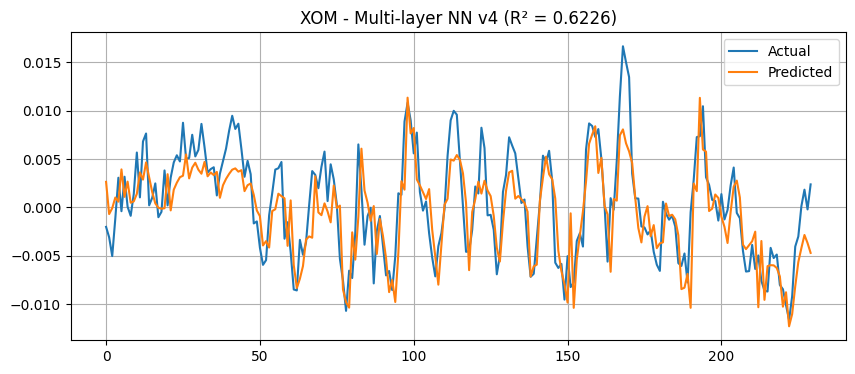


Training CVX...
Training CVX model (v4)...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 6.5065
Epoch 1: val_loss improved from inf to 0.51283, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 4.3115 - val_loss: 0.5128 - learning_rate: 0.0010
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5202
Epoch 2: val_loss improved from 0.51283 to 0.48574, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.4546 - val_loss: 0.4857 - learning_rate: 0.0010
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.7936
Epoch 3: val_loss improved from 0.48574 to 0.47198, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.7707 - val_loss: 0.4720 - learning_rate: 0.0010
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6487
Epoch 4: val_loss improved from 0.47198 to 0.46019, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5293 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch 5/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4481
Epoch 5: val_loss improved from 0.46019 to 0.45222, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.4211 - val_loss: 0.4522 - learning_rate: 0.0010
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5760
Epoch 6: val_loss improved from 0.45222 to 0.42816, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2768 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 7/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9038
Epoch 7: val_loss improved from 0.42816 to 0.40758, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0589 - val_loss: 0.4076 - learning_rate: 0.0010
Epoch 8/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1877
Epoch 8: val_loss improved from 0.40758 to 0.39304, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0698 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 9/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.1138
Epoch 9: val_loss improved from 0.39304 to 0.37883, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2654 - val_loss: 0.3788 - learning_rate: 0.0010
Epoch 10/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3033
Epoch 10: val_loss improved from 0.37883 to 0.35317, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0140 - val_loss: 0.3532 - learning_rate: 0.0010
Epoch 11/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7662
Epoch 11: val_loss improved from 0.35317 to 0.33785, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8311 - val_loss: 0.3379 - learning_rate: 0.0010
Epoch 12/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9858
Epoch 12: val_loss improved from 0.33785 to 0.33263, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8911 - val_loss: 0.3326 - learning_rate: 0.0010
Epoch 13/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9861
Epoch 13: val_loss did not improve from 0.33263
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8177 - val_loss: 0.3337 - learning_rate: 0.0010
Epoch 14/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.0578
Epoch 14: val_loss improved from 0.33263 to 0.31761, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9302 - val_loss: 0.3176 - learning_rate: 0.0010
Epoch 15/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7380
Epoch 15: val_loss improved from 0.31761 to 0.31121, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7699 - val_loss: 0.3112 - learning_rate: 0.0010
Epoch 16/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0007
Epoch 16: val_loss improved from 0.31121 to 0.29675, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8413 - val_loss: 0.2968 - learning_rate: 0.0010
Epoch 17/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8127
Epoch 17: val_loss improved from 0.29675 to 0.28746, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7111 - val_loss: 0.2875 - learning_rate: 0.0010
Epoch 18/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0105
Epoch 18: val_loss improved from 0.28746 to 0.28662, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8376 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 19/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5957
Epoch 19: val_loss improved from 0.28662 to 0.28119, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6696 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 20/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5386
Epoch 20: val_loss improved from 0.28119 to 0.27098, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6538 - val_loss: 0.2710 - learning_rate: 0.0010
Epoch 21/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5802
Epoch 21: val_loss improved from 0.27098 to 0.26435, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6662 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 22/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7316
Epoch 22: val_loss improved from 0.26435 to 0.25611, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7888 - val_loss: 0.2561 - learning_rate: 0.0010
Epoch 23/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7476
Epoch 23: val_loss improved from 0.25611 to 0.25100, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6427 - val_loss: 0.2510 - learning_rate: 0.0010
Epoch 24/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7035
Epoch 24: val_loss improved from 0.25100 to 0.24876, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6270 - val_loss: 0.2488 - learning_rate: 0.0010
Epoch 25/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5224
Epoch 25: val_loss improved from 0.24876 to 0.24777, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6286 - val_loss: 0.2478 - learning_rate: 0.0010
Epoch 26/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8986
Epoch 26: val_loss improved from 0.24777 to 0.24658, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7298 - val_loss: 0.2466 - learning_rate: 0.0010
Epoch 27/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5995
Epoch 27: val_loss did not improve from 0.24658
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5606 - val_loss: 0.2490 - learning_rate: 0.0010
Epoch 28/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5376
Epoch 28: val_loss did not improve from 0.24658
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5736 - val_loss: 0.2517 - learning_rate: 0.0010
Epoch 29/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7897
Epoch 29: val_loss did not improve from 0.24658
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6314 - val_loss: 0.2548 - learning_rate: 0.0010
Epoch 30/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6976
Epoch 30: val_loss did not improve from 0.24658
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5937 - val_loss: 0.2549 - learning_rate: 0.0010
Epoch 31/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/st

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6356 - val_loss: 0.2453 - learning_rate: 0.0010
Epoch 35/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6753
Epoch 35: val_loss improved from 0.24525 to 0.24273, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5771 - val_loss: 0.2427 - learning_rate: 0.0010
Epoch 36/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4301
Epoch 36: val_loss improved from 0.24273 to 0.24103, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5212 - val_loss: 0.2410 - learning_rate: 0.0010
Epoch 37/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6173
Epoch 37: val_loss improved from 0.24103 to 0.23906, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5402 - val_loss: 0.2391 - learning_rate: 0.0010
Epoch 38/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5301
Epoch 38: val_loss improved from 0.23906 to 0.23686, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5305 - val_loss: 0.2369 - learning_rate: 0.0010
Epoch 39/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5315
Epoch 39: val_loss improved from 0.23686 to 0.23506, saving model to ../models/saved_model/CVX_weights/best_checkpoint_v4.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5782 - val_loss: 0.2351 - learning_rate: 0.0010
Epoch 40/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4572
Epoch 40: val_loss did not improve from 0.23506
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4806 - val_loss: 0.2351 - learning_rate: 0.0010
Epoch 41/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4423
Epoch 41: val_loss did not improve from 0.23506
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5160 - val_loss: 0.2367 - learning_rate: 0.0010
Epoch 42/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5275
Epoch 42: val_loss did not improve from 0.23506
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5172 - val_loss: 0.2403 - learning_rate: 0.0010
Epoch 43/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3811
Epoch 43: val_loss did not improve from 0.23506
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5095 - val_loss: 0.2408 - learning_rate: 0.0010
Epoch 44/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/st

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


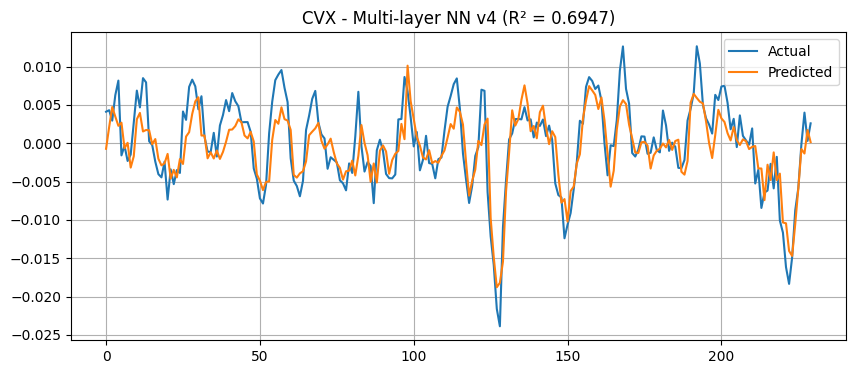


SUMMARY OF MULTI-LAYER NN MODEL V4
AAPL: MSE = 0.000013, R² = 0.6791
MSFT: MSE = 0.000010, R² = 0.6699
JPM: MSE = 0.000025, R² = 0.3315
BAC: MSE = 0.000011, R² = 0.7440
XOM: MSE = 0.000011, R² = 0.6226
CVX: MSE = 0.000010, R² = 0.6947


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
from sklearn.feature_selection import mutual_info_regression, SelectKBest

# Reproducibility
import random
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

tickers = ['AAPL', 'MSFT', 'JPM', 'BAC', 'XOM', 'CVX']
results = {}

for ticker in tickers:
    print(f"\nTraining {ticker}...")
    df = pd.read_csv(f'../data/processed/{ticker}_processed.csv', index_col='Date', parse_dates=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # === Enhanced Feature Engineering ===
    # Price-based features
    df['Return'] = df['Close'].pct_change()
    df['Return_Abs'] = np.abs(df['Return'])
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Return lags - capture autocorrelation patterns
    for i in range(1, 10):
        df[f'Lag_{i}'] = df['Return'].shift(i)
        if i <= 5:  # Create interaction terms for closer lags
            df[f'Lag_{i}_squared'] = df[f'Lag_{i}']**2
            
    # Momentum indicators at different timeframes
    for window in [5, 10, 20, 30]:
        df[f'Momentum_{window}'] = df['Close'] - df['Close'].shift(window)
        df[f'Momentum_Ratio_{window}'] = df['Close'] / df['Close'].shift(window)
    
    # Moving averages
    for window in [5, 10, 20, 50, 100]:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
        # Distance to moving average (normalized)
        df[f'Close_MA_{window}_Ratio'] = df['Close'] / df[f'MA_{window}']
    
    # Volatility features at different timeframes
    for window in [5, 10, 20, 30]:
        df[f'Volatility_{window}'] = df['Return'].rolling(window=window).std()
        # Add normalized volatility
        if window in [5, 10]:
            df[f'Volatility_Ratio_{window}'] = df[f'Volatility_{window}'] / df[f'Volatility_{window}'].rolling(window=5).mean()
    
    # RSI at multiple timeframes
    for window in [6, 14, 21]:
        delta = df['Close'].diff()
        gain = delta.clip(lower=0).rolling(window).mean()
        loss = -delta.clip(upper=0).rolling(window).mean()
        rs = gain / (loss.replace(0, np.finfo(float).eps))
        df[f'RSI_{window}'] = 100 - (100 / (1 + rs))
    
    # MACD variants
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    df['MACD_hist_diff'] = df['MACD_hist'].diff() # Change in histogram
    
    # Bollinger Bands
    for window in [20]:
        middle_band = df['Close'].rolling(window=window).mean()
        std_dev = df['Close'].rolling(window=window).std()
        df[f'BB_upper_{window}'] = middle_band + (std_dev * 2)
        df[f'BB_lower_{window}'] = middle_band - (std_dev * 2)
        df[f'BB_width_{window}'] = (df[f'BB_upper_{window}'] - df[f'BB_lower_{window}']) / middle_band
        df[f'BB_position_{window}'] = (df['Close'] - df[f'BB_lower_{window}']) / (df[f'BB_upper_{window}'] - df[f'BB_lower_{window}'])
    
    # Rate of Change
    for window in [5, 10, 21]:
        df[f'ROC_{window}'] = df['Close'].pct_change(window) * 100
    
    # Volume features (if available)
    if 'Volume' in df.columns:
        df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
        df['Log_Volume'] = np.log(df['Volume'] + 1)
        df['Volume_Change'] = df['Volume'].pct_change()
        
        # Volume moving averages
        for window in [5, 10, 20]:
            df[f'Volume_SMA_{window}'] = df['Volume'].rolling(window).mean()
            df[f'Volume_Ratio_{window}'] = df['Volume'] / df[f'Volume_SMA_{window}']
        
        # Volume and price relationships
        df['Volume_Return_Ratio'] = df['Volume'] / (df['Return_Abs'] + 0.001)
        df['Volume_Close_Ratio'] = df['Volume'] / df['Close']

    # === Target: 5-day smoothed forward log return (v4) ===
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Target'] = df['LogReturn'].shift(-1).rolling(5).mean() # Changed from 3 to 5

    # Drop rows with NaN values
    df = df.dropna()
    
    # Handle outliers - clip extreme values using percentiles
    for col in df.columns:
        if col != 'Close' and col != 'Target':  # Don't clip the Close price or target
            lower_bound = df[col].quantile(0.005)
            upper_bound = df[col].quantile(0.995)
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    # Feature selection using mutual information
    if df.shape[1] > 30:  # If we have many features
        X_temp = df.drop(columns=['Close', 'Target', 'LogReturn', 'Return'])
        y_temp = df['Target']
        
        # Calculate mutual information scores
        mi_scores = mutual_info_regression(X_temp, y_temp)
        mi_df = pd.DataFrame({'Feature': X_temp.columns, 'MI_Score': mi_scores})
        mi_df = mi_df.sort_values('MI_Score', ascending=False)
        
        # Select top 25 features + any essential ones we want to keep (Reverted to 25 for v4)
        top_features = mi_df.head(25)['Feature'].tolist() 
        essential_features = [col for col in X_temp.columns if 'RSI' in col or 'MACD' in col or 'Momentum' in col or 'Volatility' in col]
        selected_features = list(set(top_features + essential_features))
        
        # Create feature dataframe with only selected features
        X = df[selected_features]
    else:
        # Drop unused columns
        X = df.drop(columns=['Return', 'Close', 'Target', 'LogReturn', 'Log_Return'])
    
    y = df['Target']

    # === Normalize target ===
    y_mean, y_std = y.mean(), y.std()
    y_train, y_test = train_test_split(y, shuffle=False, test_size=0.2)
    y_train_norm = (y_train - y_mean) / y_std
    y_test_norm = (y_test - y_mean) / y_std

    # === Train-test split ===
    X_train, X_test = train_test_split(X, shuffle=False, test_size=0.2)

    # Create a more robust scaling approach
    scaler = RobustScaler()  # Less influenced by outliers
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # === Effective Neural Network Architecture (v4) ===
    # Build a well-balanced architecture with appropriate regularization
    
    # Build Sequential model
    model = Sequential([
        Dense(192, activation='relu', input_shape=(X_train_scaled.shape[1],), 
              kernel_regularizer=l2(0.0001)), 
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(96, activation='relu', kernel_regularizer=l2(0.0001)), 
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(48, activation='relu', kernel_regularizer=l2(0.0001)), 
        BatchNormalization(),
        Dropout(0.2),

        Dense(24, activation='relu', kernel_regularizer=l2(0.0001)), 
        BatchNormalization(),
        Dropout(0.1),
        
        Dense(1)
    ])
    
    # Compile with Adam optimizer
    optimizer = Adam(learning_rate=0.001) # Reverted learning rate for v4
    model.compile(optimizer=optimizer, loss='mse')

    # === Training Strategy (v4) ===
    
    # Create a weight folder for this ticker
    model_folder = f'../models/saved_model/{ticker}_weights'
    os.makedirs(model_folder, exist_ok=True)
    
    # Model checkpoint to save the best model
    checkpoint = ModelCheckpoint(
        filepath=f'{model_folder}/best_checkpoint_v4.h5', # Save best checkpoint for v4
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    
    # Early stopping with appropriate patience
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=25, # Adjusted for v4
        restore_best_weights=True,
        mode='min',
        verbose=1
    )
    
    # Learning rate reduction on plateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Adjusted for v4
        patience=8,  # Adjusted for v4
        min_lr=1e-6,
        mode='min',
        verbose=1
    )
    
    # Train model with validation split
    print(f"Training {ticker} model (v4)...") # Indicate v4 training
    history = model.fit(
        X_train_scaled, y_train_norm,
        validation_split=0.2,
        epochs=100, 
        batch_size=64, # Changed batch size for v4
        verbose=1,
        callbacks=[early_stop, reduce_lr, checkpoint]
    )

    # Save model
    os.makedirs('../models/saved_model', exist_ok=True)
    model.save(f'../models/saved_model/{ticker}_multi_layer_v4.h5') # Save as v4

    # === Predict and Evaluate ===
    y_pred_norm = model.predict(X_test_scaled).flatten()
    y_pred = y_pred_norm * y_std + y_mean
    y_test_actual = y_test.values

    mse = mean_squared_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)
    results[ticker] = (mse, r2)

    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{ticker} - Multi-layer NN v4 (R² = {r2:.4f})") # Updated title
    plt.legend()
    plt.grid(True)
    plt.show()

# === Summary Output ===
print("\nSUMMARY OF MULTI-LAYER NN MODEL V4") # Updated summary title
for ticker, (mse, r2) in results.items():
    print(f"{ticker}: MSE = {mse:.6f}, R² = {r2:.4f}")